/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU: True


100%|██████████████████████████████| 20000/20000 [02:45<00:00, 120.76it/s, Iter=2e+4, Loss=3.48e+00]


Adam done!
Iter: 21000 Loss: 0.0711410716176033
Iter: 22000 Loss: 0.03956204652786255
Iter: 23000 Loss: 0.025319969281554222
Iter: 24000 Loss: 0.018074043095111847
Iter: 25000 Loss: 0.013566268607974052
Iter: 26000 Loss: 0.009266899898648262
Iter: 27000 Loss: 0.005914413370192051
Iter: 28000 Loss: 0.0034601669758558273
Iter: 29000 Loss: 0.0023633255623281
Iter: 30000 Loss: 0.0017725748475641012
Iter: 31000 Loss: 0.0013678979594260454
LBGFS done!
Test_L2error: 1.31e-02
Training time: 323.87
[]


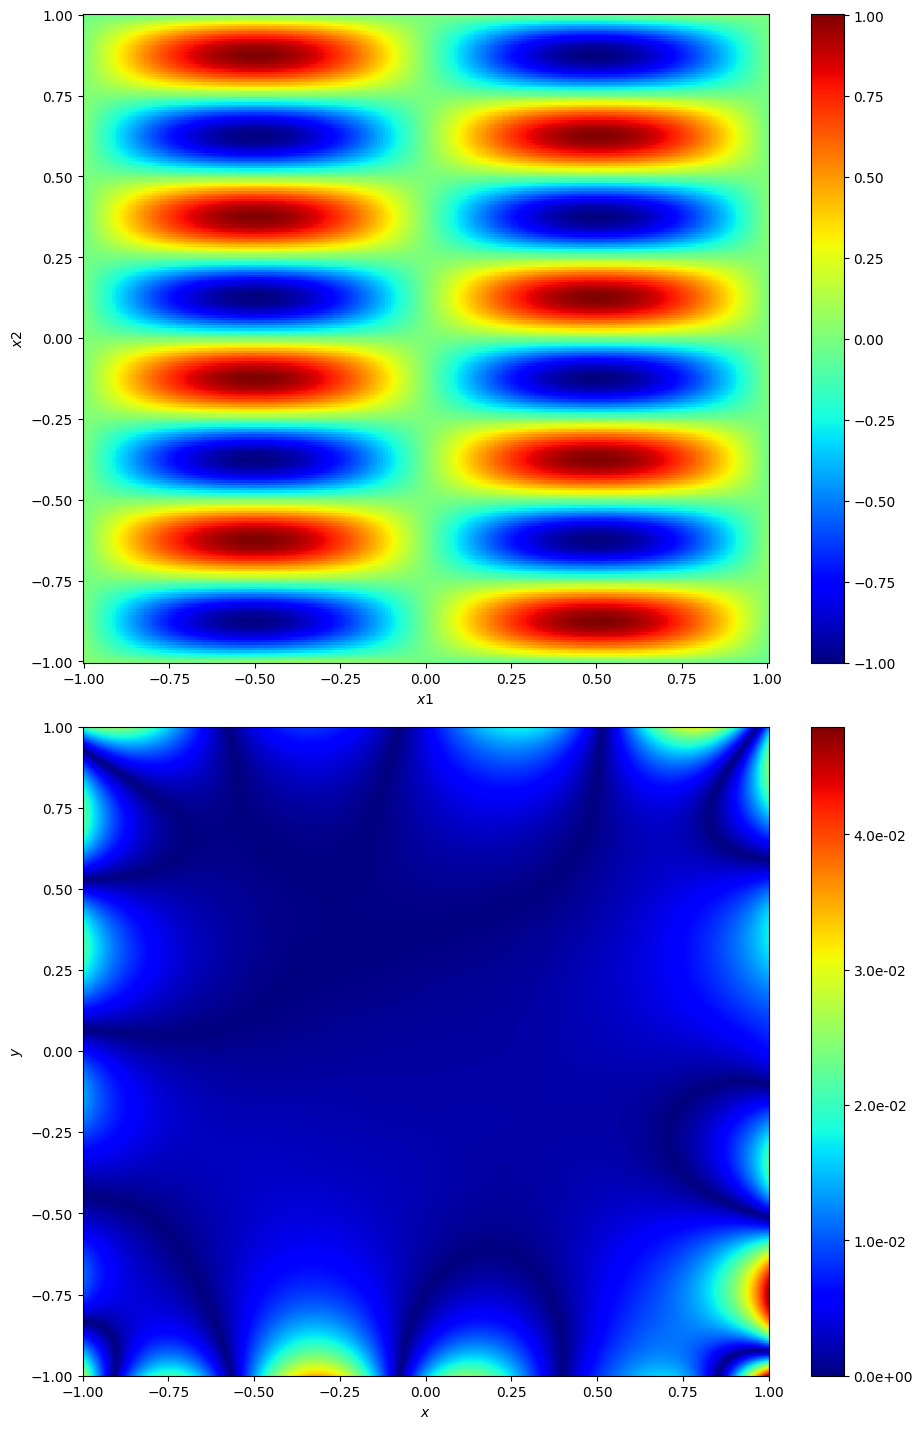

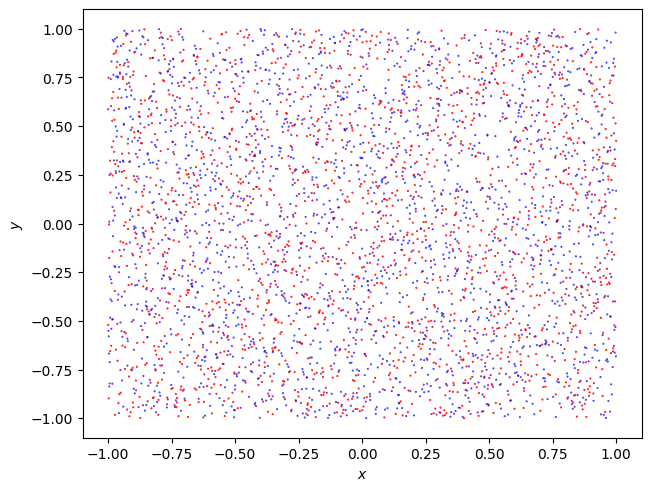

In [1]:
import os
import time
import numpy as np
import torch
from matplotlib import pyplot as plt, gridspec
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm, trange
from pyDOE import lhs
from collections import OrderedDict
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device('cuda')
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)


def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float()
    if use_gpu:
        temp = temp.cuda()
    return temp


def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data

def sinAddcos(x):
    return 0.5 * (torch.sin(x) + torch.cos(x))

# class Net(nn.Module):

#     def __init__(self, layers):
#         super(Net, self).__init__()
#         self.layers = layers
#         self.indim = layers[0]
#         self.outdim = layers[-1]
#         self.hidden_units = layers[1:-1]
#         self.dense_layers = nn.ModuleList()
#         self.iter = 0
#         # if isinstance(hidden_units, int):
#         #     hidden_units = [hidden_units]
#         # print(f"hidden_units inside Dense_ScaleNet: {hidden_units}, type: {type(hidden_units)}")

#         input_layer = nn.Linear(self.indim, self.hidden_units[0])
#         nn.init.xavier_normal_(input_layer.weight)
#         nn.init.uniform_(input_layer.bias, -1, 1)
#         self.dense_layers.append(input_layer)

#         for i_layer in range(len(self.hidden_units) - 1):
#             if i_layer == 0:
#                 hidden_layer = nn.Linear(2 * self.hidden_units[i_layer], self.hidden_units[i_layer + 1])
#                 nn.init.xavier_normal_(hidden_layer.weight)
#                 nn.init.uniform_(hidden_layer.bias, -1, 1)
#             else:
#                 hidden_layer = nn.Linear(self.hidden_units[i_layer], self.hidden_units[i_layer + 1])
#                 nn.init.xavier_normal_(hidden_layer.weight)
#                 nn.init.uniform_(hidden_layer.bias, -1, 1)
#             self.dense_layers.append(hidden_layer)

#         out_layer = nn.Linear(self.hidden_units[-1], self.outdim)
#         nn.init.xavier_normal_(out_layer.weight)
#         nn.init.uniform_(out_layer.bias, -1, 1)
#         self.dense_layers.append(out_layer)

#     def forward(self, inputs, sFourier=0.5):
#         # ------ dealing with the input data ---------------
#         scale= [30,31,32,33,34,35,36,37,38,39,40,41,42,42,43,44,45,46,46,47,48,49]
#         # scale= np.arange(1, 30)
#         #scale = [1, 2, 4, 6, 8]

#         dense_in = self.dense_layers[0]
#         H = dense_in(inputs)

#         Unit_num = int(self.hidden_units[0] / len(scale))
#         mixcoe = np.repeat(scale, Unit_num)
#         mixcoe = np.concatenate((mixcoe, np.ones([self.hidden_units[0] - Unit_num * len(scale)]) * scale[-1]))
#         mixcoe = mixcoe.astype(np.float32)
#         torch_mixcoe = torch.from_numpy(mixcoe)
#         torch_mixcoe = torch_mixcoe.to(device)
#         H = sFourier * torch.cat([torch.cos(H * torch_mixcoe), torch.sin(H * torch_mixcoe)], dim=-1)

#         #  ---resnet(one-step skip connection for two consecutive layers if have equal neurons）---
#         # hiddens_record = self.hidden_units[0]
#         for k in range(len(self.hidden_units) - 1):
#             # H_pre = H
#             dense_layer = self.dense_layers[k + 1]
#             H = dense_layer(H)
#             H = sinAddcos(H)
#             # if (self.hidden_units[k+1] == hiddens_record) and (k != 0):
#             #     H = H + H_pre
#             # hiddens_record = self.hidden_units[k+1]

#         dense_out = self.dense_layers[-1]
#         H = dense_out(H)
#         out_results = H
#         return out_results
    
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

class Model:
    def __init__(self, net, x_label, x_labels, x_f_loss_fun,
                 x_test, x_test_exact
                 ):

        self.x_label_s = None
        self.x_f_s = None
        self.s_collect = []

        self.optimizer_LBGFS = None
        self.net = net

        self.x_label = x_label
        self.x_labels = x_labels

        self.x_f_N = None
        self.x_f_M = None

        self.x_f_loss_fun = x_f_loss_fun

        self.x_test = x_test
        self.x_test_exact = x_test_exact

        self.start_loss_collect = False
        self.x_label_loss_collect = []
        self.x_f_loss_collect = []
        self.x_test_estimate_collect = []
        self.l2_collect = []

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_e, loss_l):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
               + torch.exp(-self.x_label_s) * loss_l.detach() + self.x_label_s
        return loss

    def true_loss(self, loss_e, loss_l):
        return torch.exp(-self.x_f_s.detach()) * loss_e + torch.exp(-self.x_label_s.detach()) * loss_l

    # computer backward loss
    def epoch_loss(self):
        x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        loss_equation = torch.mean(self.x_f_loss_fun(x_f, self.train_U) ** 2)

        loss_label = torch.mean((self.train_U(self.x_label) - self.x_labels) ** 2)

        if self.start_loss_collect:
            self.x_f_loss_collect.append([self.net.iter, loss_equation.item()])
            self.x_label_loss_collect.append([self.net.iter, loss_label.item()])
        return loss_equation, loss_label

    # computer backward loss
    def LBGFS_epoch_loss(self):
        self.optimizer_LBGFS.zero_grad()
        x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        loss_equation = torch.mean(self.x_f_loss_fun(x_f, self.train_U) ** 2)
        loss_label = torch.mean((self.train_U(self.x_label) - self.x_labels) ** 2)

        if self.start_loss_collect:
            self.x_f_loss_collect.append([self.net.iter, loss_equation.item()])
            self.x_label_loss_collect.append([self.net.iter, loss_label.item()])

        loss = self.true_loss(loss_equation, loss_label)
        loss.backward()
        # error = self.evaluate()
        # self.l2_collect.append([self.net.iter, error])
        self.net.iter += 1
        # error = self.evaluate()
        # self.l2_collect.append([self.net.iter, error])
        if self.net.iter % 1000 == 0:
            print('Iter:', self.net.iter, 'Loss:', loss.item())
        #print('Iter:', self.net.iter, 'Loss:', loss.item())
        return loss

    def evaluate(self):
        pred = self.train_U(self.x_test).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error

    def run_baseline(self):
        optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
        self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                 max_iter=lbgfs_iter)
        pbar = trange(adam_iter, ncols=100)
        for i in pbar:
            optimizer_adam.zero_grad()
            loss_e, loss_label = self.epoch_loss()
            loss = self.true_loss(loss_e, loss_label)
            loss.backward()
            optimizer_adam.step()
            self.net.iter += 1
            pbar.set_postfix({'Iter': self.net.iter,
                              'Loss': '{0:.2e}'.format(loss.item())
                              })

        print('Adam done!')
        self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
        print('LBGFS done!')

        error = self.evaluate()
        print('Test_L2error:', '{0:.2e}'.format(error))

    def run_AM(self):
        for move_count in range(AM_count):
            self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                     max_iter=lbgfs_iter)
            optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
            pbar = trange(adam_iter, ncols=100)

            for i in pbar:
                optimizer_adam.zero_grad()
                loss_equation, loss_label = self.epoch_loss()
                loss = self.true_loss(loss_equation, loss_label)
                loss.backward()
                # error = self.evaluate()
                # self.l2_collect.append([self.net.iter, error])
                self.net.iter += 1
                
                optimizer_adam.step()
                pbar.set_postfix({'Iter': self.net.iter,
                                  'Loss': '{0:.2e}'.format(loss.item())
                                  })

            print('Adam done!')
            # if move_count == AM_count-1:
            #     self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
            #     print('LBGFS done!')
            self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
            print('LBGFS done!')

            error = self.evaluate()
            print('change_counts', move_count, 'Test_L2error:', '{0:.2e}'.format(error))
            self.x_test_estimate_collect.append([move_count, '{0:.2e}'.format(error)])

            if AM_type == 0:
                x_init = random_fun(100000)
                x_init_residual = abs(self.x_f_loss_fun(x_init, self.train_U))
                x_init_residual = x_init_residual.cpu().detach().numpy()
                err_eq = np.power(x_init_residual, AM_K) / np.power(x_init_residual, AM_K).mean()
                err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=err_eq_normalized)
                self.x_f_M = x_init[X_ids]

            elif AM_type == 1:
                x_init = random_fun(100000)
                x = Variable(x_init, requires_grad=True)
                u = self.train_U(x)
                dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                grad_x1 = dx[:, [0]].squeeze()
                grad_x2 = dx[:, [1]].squeeze()
                dx = torch.sqrt(1 + grad_x1 ** 2 + grad_x2 ** 2).cpu().detach().numpy()
                err_dx = np.power(dx, AM_K) / np.power(dx, AM_K).mean()
                p = (err_dx / sum(err_dx))
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=p)
                self.x_f_M = x_init[X_ids]

    def run_AM_AW1(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_label_s = nn.Parameter(self.x_label_s, requires_grad=True)

        for move_count in range(AM_count):
            self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                     max_iter=lbgfs_iter)
            optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
            optimizer_adam_weight = torch.optim.Adam([self.x_f_s] + [self.x_label_s],
                                                     lr=AW_lr)

            pbar = trange(adam_iter, ncols=100)
            for i in pbar:
                self.s_collect.append([self.net.iter, self.x_f_s.item(), self.x_label_s.item()])

                loss_e, loss_label = self.epoch_loss()

                optimizer_adam.zero_grad()
                loss = self.true_loss(loss_e, loss_label)
                loss.backward()
                optimizer_adam.step()
                self.net.iter += 1
                # error = self.evaluate()
                # self.l2_collect.append([self.net.iter, error])
                pbar.set_postfix({'Iter': self.net.iter,
                                  'Loss': '{0:.2e}'.format(loss.item())
                                  })

                optimizer_adam_weight.zero_grad()
                loss = self.likelihood_loss(loss_e, loss_label)
                loss.backward()
                optimizer_adam_weight.step()

            print('Adam done!')
            # if move_count == AM_count-1:
            #     self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
            #     print('LBGFS done!')
            self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
            print('LBGFS done!')

            error = self.evaluate()
            print('change_counts', move_count, 'Test_L2error:', '{0:.2e}'.format(error))
            self.x_test_estimate_collect.append([move_count, '{0:.2e}'.format(error)])

            if AM_type == 0:
                x_init = random_fun(100000)
                x_init_residual = abs(self.x_f_loss_fun(x_init, self.train_U))
                x_init_residual = x_init_residual.cpu().detach().numpy()
                err_eq = np.power(x_init_residual, AM_K) / np.power(x_init_residual, AM_K).mean()
                err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=err_eq_normalized)
                self.x_f_M = x_init[X_ids]

            elif AM_type == 1:
                x_init = random_fun(100000)
                x = Variable(x_init, requires_grad=True)
                u = self.train_U(x)
                dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                grad_x1 = dx[:, [0]].squeeze()
                grad_x2 = dx[:, [1]].squeeze()
                dx = torch.sqrt(1 + grad_x1 ** 2 + grad_x2 ** 2).cpu().detach().numpy()
                err_dx = np.power(dx, AM_K) / np.power(dx, AM_K).mean()
                p = (err_dx / sum(err_dx))
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=p)
                self.x_f_M = x_init[X_ids]

    def run_AM_AW(self):
        self.run_AM()
        self.net.iter = 0
        self.start_loss_collect = True
        print('AW start!')
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_label_s = nn.Parameter(self.x_label_s, requires_grad=True)

        optimizer_adam_weight = torch.optim.Adam([self.x_f_s] + [self.x_label_s],
                                                 lr=AW_lr)

        self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                 max_iter=lbgfs_iter)
        optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)

        pbar = trange(adam_iter, ncols=100)
        for i in pbar:
            self.s_collect.append([self.net.iter, self.x_f_s.item(), self.x_label_s.item()])

            loss_e, loss_label = self.epoch_loss()

            optimizer_adam.zero_grad()
            loss = self.true_loss(loss_e, loss_label)
            loss.backward()
            optimizer_adam.step()
            self.net.iter += 1
            pbar.set_postfix({'Iter': self.net.iter,
                              'Loss': '{0:.2e}'.format(loss.item())
                              })

            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_e, loss_label)
            loss.backward()
            optimizer_adam_weight.step()

        print('Adam done!')
        self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
        print('LBGFS done!')

        error = self.evaluate()
        print('change_counts', -1, 'Test_L2error:', '{0:.2e}'.format(error))
        self.x_test_estimate_collect.append([-1, '{0:.2e}'.format(error)])

    def train(self):

        self.x_f_N = random_fun(N)
        self.x_f_M = random_fun(M)

        # self.x_f_s = is_cuda(-torch.log(torch.tensor(1.).float()))
        # self.x_label_s = is_cuda(
        #     -torch.log(torch.tensor(100.).float()))  # 0.5*torch.exp(-self.x_label_s.detach()) = 100

        self.x_f_s = is_cuda(torch.tensor(0.).float())
        self.x_label_s = is_cuda(torch.tensor(0.).float())

        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AM()
        elif model_type == 2:
            self.run_AM_AW1()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)


def x_f_loss_fun(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x)
    d = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)
    u_x1 = d[0][:, 0].unsqueeze(-1)
    u_x2 = d[0][:, 1].unsqueeze(-1)
    u_x1x1 = torch.autograd.grad(u_x1, x, grad_outputs=torch.ones_like(u_x1), create_graph=True)[0][:, 0].unsqueeze(-1)
    u_x2x2 = torch.autograd.grad(u_x2, x, grad_outputs=torch.ones_like(u_x2), create_graph=True)[0][:, 1].unsqueeze(-1)
    u_exact = torch.sin(a1 * torch.pi * x[:, [0]]) * torch.sin(a2 * torch.pi * x[:, [1]])
    f = -(a1 * torch.pi) ** 2 * u_exact - (a2 * torch.pi) ** 2 * u_exact + k ** 2 * u_exact - \
        (u_x1x1 + u_x2x2 + k ** 2 * u)
    return f


def draw_exact():
    # 获取预测值和精确值
    predict_np = model.predict_U(x_test).cpu().detach().numpy()
    u_test_np = x_test_exact.cpu().detach().numpy()
    u_test = x_test_exact.cpu().detach().numpy()
    # 创建网格
    XX1, XX2 = np.meshgrid(x1, x2)

    
    fig = plt.figure(figsize=(9.6, 14.4))  # 宽度和高度都增大为原来的1.5倍

    # 第一个子图：Predicted Solution
    plt.subplot(2, 1, 1)  # 1行2列，第1个位置
    e = np.reshape(predict_np, (XX1.shape[0], XX1.shape[1]))
    plt.pcolormesh(XX1, XX2, e, shading='auto', cmap='jet')
    plt.colorbar()
    # e = np.reshape(predict_np, (XX1.shape[0], XX1.shape[1]))
    # plot = plt.pcolormesh(XX1, XX2, e, shading='gouraud', cmap='jet', vmin=0, vmax=np.max(e))
    # plt.colorbar(plot, format="%1.1e")
    plt.xlabel('$x1$')
    plt.ylabel('$x2$')
    #plt.title(r'Pred $u(x)$')

    # 第二个子图：Error
    plt.subplot(2, 1, 2)  # 1行2列，第2个位置
    e = np.reshape(abs(predict_np - u_test), (XX1.shape[0], XX1.shape[1]))
    plot = plt.pcolormesh(XX1, XX2, e, shading='gouraud', cmap='jet', vmin=0, vmax=np.max(e))
    plt.colorbar(plot, format="%1.1e")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    #plt.title('$Error$')

    # 调整布局，确保图形不重叠
    plt.tight_layout()

    # 保存为PDF文件
    plt.savefig('Helmholtz_pred_and_error-PINN.pdf')

    # 显示图形
    plt.show()
    
def draw_points(points,N_points=None):
    points = points.cpu().detach().numpy()
    points_bc = x_bc.cpu().detach().numpy()
    if N_points is not None:
        adds = N_points.cpu().detach().numpy()
        #plt.plot(adds[:, [0]], adds[:, [1]], 'kx', markersize=4)
    fig, ax = plt.subplots(layout='constrained', figsize=(6.4, 4.8))
    xs, xe, ys, ye = lb[0], ub[0], lb[1], ub[1]
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.scatter(points[:, 0], points[:, 1], c='r', marker='.', s=np.ones_like(points[:, 0]), alpha=1.0)
    ax.scatter(adds[:, 0], adds[:, 1], c='b', marker='.', s=np.ones_like(adds[:, 0]), alpha=0.8)
    #ax.scatter(points_bc[:, 0], points_bc[:, 1], c='b', marker='.', s=np.ones_like(points_bc[:, 0]), alpha=0.3)
    #ax.legend(loc='upper right', fontsize=12)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.savefig('Hel-PINN.pdf')
    plt.show()    

def draw_exact_points(points, N_points=None, show_exact=True):
    if show_exact:
        u_test_np = x_test_exact.cpu().detach().numpy()
        XX1, XX2 = np.meshgrid(x1, x2)
        e = np.reshape(u_test_np, (XX1.shape[0], XX1.shape[1]))
        plt.pcolor(XX1, XX2, e, shading='auto', cmap='jet')
        plt.colorbar()
        plt.title(r'Exact $u(x,y)$')
    if N_points is not None:
        adds = N_points.cpu().detach().numpy()
        plt.plot(adds[:, [0]], adds[:, [1]], 'kx', markersize=4, clip_on=False)

    points = points.cpu().detach().numpy()
    plt.plot(points[:, [0]], points[:, [1]], 'rx', markersize=4)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$y$', fontsize=20)
    plt.savefig('Helmholtz_xnm-WAM-AW.pdf')
    plt.show()


def draw_residual():
    f = x_f_loss_fun(x_test, model.train_U)
    f = f.cpu().detach().numpy()
    XX1, XX2 = np.meshgrid(x1, x2)
    e = np.reshape(abs(f), (XX1.shape[0], XX1.shape[1]))
    plt.pcolor(XX1, XX2, e, shading='auto', cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$y$', fontsize=20)
    plt.title('$Residual$', fontsize=20)
    plt.tight_layout()
    plt.savefig('Helmholtz_residual-WAM-AW.pdf')
    plt.show()


def draw_error():
    predict_np = model.predict_U(x_test).cpu().detach().numpy()
    u_test = x_test_exact.cpu().detach().numpy()
    XX1, XX2 = np.meshgrid(x1, x2)
    e = np.reshape(abs(predict_np - u_test), (XX1.shape[0], XX1.shape[1]))
    plt.pcolor(XX1, XX2, e, shading='auto', cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$y$', fontsize=20)
    plt.title('$Error$', fontsize=20)
    plt.tight_layout()
    plt.savefig('Helmholtz_error-WAM-AW.pdf')
    plt.show()


def draw_epoch_loss():
    x_label_loss_collect = np.array(model.x_label_loss_collect)
    x_f_loss_collect = np.array(model.x_f_loss_collect)
    plt.subplot(2, 1, 1)
    plt.yscale('log')
    plt.plot(x_label_loss_collect[:, 0], x_label_loss_collect[:, 1], 'b-', label='Label_loss')
    plt.xlabel('$Epoch$')
    plt.ylabel('$Loss$')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.yscale('log')
    plt.plot(x_f_loss_collect[:, 0], x_f_loss_collect[:, 1], 'r-', label='PDE_loss')
    plt.xlabel('$Epoch$')
    plt.ylabel('$Loss$')
    plt.legend()
    plt.show()


def draw_epoch_w():
    s_collect = np.array(model.s_collect)
    np.savetxt('s_WAM-AW.npy', s_collect)
    plt.rc('legend', fontsize=16)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 1]), 'b-', label='$e^{-s_{r}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 2]), 'r-', label='$e^{-s_{b}}$')
    plt.xlabel('$Iters$', fontsize=20)
    plt.ylabel('$\lambda$', fontsize=20)
    plt.legend()
    plt.savefig('Helmholtz_S_WAM-AW.pdf', fontsize=20)
    plt.show()



def draw_some_t():
    predict_np = model.predict_U(x_test).cpu().detach().numpy()
    u_test_np = x_test_exact.cpu().detach().numpy()
    XX1, XX2 = np.meshgrid(x1, x2)
    u_pred = np.reshape(predict_np, (XX1.shape[0], XX1.shape[1]))
    u_test = np.reshape(u_test_np, (XX1.shape[0], XX1.shape[1]))
    gs1 = gridspec.GridSpec(2, 2)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x2, u_test.T[int((rc1 + 1) / (2 / 256)), :], 'b-', linewidth=2, label='Exact')
    ax.plot(x2, u_pred.T[int((rc1 + 1) / (2 / 256)), :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$y$', fontsize=20)
    ax.set_ylabel('$u(x,y)$', fontsize=20)
    ax.set_title('$x = ' + str(rc1) + '$', fontsize=20)
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x2, u_test.T[:, int((rc2 + 1) / (2 / 256))], 'b-', linewidth=2, label='Exact')
    ax.plot(x2, u_pred.T[:, int((rc2 + 1) / (2 / 256))], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$u(x,y)$', fontsize=20)
    ax.set_title('$y = ' + str(rc2) + '$', fontsize=20)
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    ax = plt.subplot(gs1[1, 0])
    ax.plot(x2, u_test.T[int((rc3 + 1) / (2 / 256)), :], 'b-', linewidth=2, label='Exact')
    ax.plot(x2, u_pred.T[int((rc3 + 1) / (2 / 256)), :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$y$', fontsize=20)
    ax.set_ylabel('$u(x,y)$', fontsize=20)
    ax.set_title('$x = ' + str(rc3) + '$', fontsize=20)
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    ax = plt.subplot(gs1[1, 1])
    ax.plot(x2, u_test.T[:, int((rc4 + 1) / (2 / 256))], 'b-', linewidth=2, label='Exact')
    ax.plot(x2, u_pred.T[:, int((rc4 + 1) / (2 / 256))], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$u(x,y)$', fontsize=20)
    ax.set_title('$y = ' + str(rc4) + '$', fontsize=20)
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    plt.tight_layout()
    plt.savefig('Helmholtz_qie-WAM-AW.pdf')
    plt.show()
    
def draw_l2_loss():
    l2= np.array(model.l2_collect)
    plt.yscale('log')
    plt.plot(l2[:, 0], l2[:, 1], 'r-', label='relative L2')
    plt.xlabel('$Epoch$')
    plt.ylabel('$Loss$')
    plt.legend()
    plt.show()

# def draw_l2_loss():
#     relatie_error= np.array(model.l2_collect)
#     fig_1 = plt.figure(1)
#     ax = fig_1.add_subplot(1, 1, 1)
#     ax.plot(relatie_error, 'r')
#     ax.set_yscale('log')
#     ax.set_xlabel('iterations')
#     ax.set_ylabel('relative_error')
#     plt.legend()
#     plt.grid(linestyle=":")
#     plt.tight_layout()
#     plt.show()


if __name__ == '__main__':
    lb = np.array([-1.0, -1.0])
    ub = np.array([1.0, 1.0])

    #layers = [2, 200, 200, 200, 200, 200, 1]
    layers = [2, 40, 40, 40, 40, 40, 1]
    #layers = [2, 125, 200, 100, 100, 80,1]
    net = is_cuda(Net(layers))

    N = 2000
    M = 2000
    Nbc = 125

    adam_iter, lbgfs_iter = 20000, 50000
    adam_lr, lbgfs_lr = 0.001, 0.5

    model_type = 0 # 0:baseline  1:AM  2:AM_AW

    AM_type = 1  # 0:RAM  1:WAM
    AM_K = 1
    AM_count = 10

    AW_lr = 0.001

    # test data
    k = 1
    a1 = 1
    a2 = 4

    rc1 = 0.5
    rc2 = 0.3
    rc3 = -0.5
    rc4 = -0.3

    exact_u = lambda x: np.sin(a1 * np.pi * x[:, [0]]) * np.sin(a2 * np.pi * x[:, [1]])
    x1 = np.expand_dims(np.linspace(-1, 1, 256), axis=1)
    x2 = np.expand_dims(np.linspace(-1, 1, 256), axis=1)
    X1, X2 = np.meshgrid(x1, x2)

    x_test_np = np.concatenate((np.vstack(np.expand_dims(X1, axis=2)), np.vstack(np.expand_dims(X2, axis=2))), axis=-1)
    solution = exact_u(x_test_np)
    x_test = is_cuda(torch.from_numpy(x_test_np).float())
    x_test_exact = is_cuda(torch.from_numpy(solution).float())

    # bc data
    x1_boundary_left = torch.cat((torch.full([Nbc, 1], -1), torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2), dim=1)
    x1_boundary_right = torch.cat((torch.full([Nbc, 1], 1), torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2), dim=1)
    x2_boundary_left = torch.cat((torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.full([Nbc, 1], -1)), dim=1)
    x2_boundary_right = torch.cat((torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.full([Nbc, 1], 1)), dim=1)

    x1_boundary_left_label = torch.from_numpy(exact_u(x1_boundary_left.numpy())).float()
    x1_boundary_right_label = torch.from_numpy(exact_u(x1_boundary_right.numpy())).float()
    x2_boundary_left_label = torch.from_numpy(exact_u(x2_boundary_left.numpy())).float()
    x2_boundary_right_label = torch.from_numpy(exact_u(x2_boundary_right.numpy())).float()

    x_bc = is_cuda(torch.cat((x1_boundary_left, x1_boundary_right, x2_boundary_left, x2_boundary_right), dim=0))
    u_bc = is_cuda(torch.cat(
        (x1_boundary_left_label, x1_boundary_right_label, x2_boundary_left_label, x2_boundary_right_label), dim=0))

    model = Model(
        net=net,
        x_label=x_bc,
        x_labels=u_bc,
        x_f_loss_fun=x_f_loss_fun,
        x_test=x_test,
        x_test_exact=x_test_exact,
    )

    model.train()
    print(model.x_test_estimate_collect)

    draw_exact()
    draw_points(model.x_f_M,N_points=model.x_f_N)
    # # draw_exact_points(model.x_f_M)
    #draw_exact_points(model.x_f_M, show_exact=False)
    # # draw_exact_points(model.x_f_M, N_points=model.x_f_N)
    # # draw_exact_points(model.x_f_M, N_points=model.x_f_N, show_exact=False)
    #draw_residual()
    #draw_error()
    #draw_some_t()
    #draw_l2_loss()
    # draw_epoch_loss()
    #draw_epoch_w()                                                                                                                                                                                                                                                                                                                                                  
